In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Dataset description
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [18]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Separate features and target
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    # Normalize the 'Amount' feature
    scaler = StandardScaler()
    X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test


In [26]:
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(128, activation=LeakyReLU(alpha=0.1))(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(64, activation=LeakyReLU(alpha=0.1))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(16, activation=LeakyReLU(alpha=0.1))(encoded)
    encoded = BatchNormalization()(encoded)
    
    # Decoder
    decoded = Dense(64, activation=LeakyReLU(alpha=0.1))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)
    decoded = Dense(128, activation=LeakyReLU(alpha=0.1))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    return autoencoder

In [33]:
def train_model(X_train, X_test, epochs=20, batch_size=256):
    input_dim = X_train.shape[1]
    autoencoder = build_autoencoder(input_dim)
    autoencoder.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error',metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping]
    )
    
    return autoencoder, history

In [40]:
def evaluate_model_and_plot(autoencoder, X_test, y_test):
    reconstructed = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)
    
    auc_roc = roc_auc_score(y_test, mse)
    precision, recall, _ = precision_recall_curve(y_test, mse)
    auc_pr = auc(recall, precision)
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    
    # Plot reconstruction error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=pd.DataFrame({'MSE': mse, 'Class': y_test}), x='MSE', hue='Class', kde=True, element='step')
    plt.title('Distribution of Reconstruction Error')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Count')
    plt.legend(title='Class', labels=['Normal', 'Fraud'])
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, mse)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return mse

In [29]:
file_path = "creditcard.csv"  # Replace with your actual file path
X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path)

In [34]:
autoencoder, history = train_model(X_train, X_test)

Epoch 1/20
891/891 [==============================] - 20s 18ms/step - loss: 46777420.0000 - accuracy: 0.9474 - val_loss: 1631305.2500 - val_accuracy: 1.0000
Epoch 2/20
891/891 [==============================] - 14s 15ms/step - loss: 2300546.2500 - accuracy: 0.9933 - val_loss: 1076621.6250 - val_accuracy: 1.0000
Epoch 3/20
891/891 [==============================] - 14s 16ms/step - loss: 2190082.7500 - accuracy: 0.9938 - val_loss: 402455.5938 - val_accuracy: 1.0000
Epoch 4/20
891/891 [==============================] - 14s 15ms/step - loss: 2157439.0000 - accuracy: 0.9941 - val_loss: 566089.6875 - val_accuracy: 1.0000
Epoch 5/20
891/891 [==============================] - 17s 20ms/step - loss: 2122432.0000 - accuracy: 0.9941 - val_loss: 462550.7812 - val_accuracy: 1.0000
Epoch 6/20
891/891 [==============================] - 20s 22ms/step - loss: 2129886.2500 - accuracy: 0.9942 - val_loss: 2047512.3750 - val_accuracy: 1.0000
Epoch 7/20
891/891 [==============================] - 18s 20ms/ste

1781/1781 [==============================] - 7s 4ms/step
AUC-ROC: 0.4543
AUC-PR: 0.0017


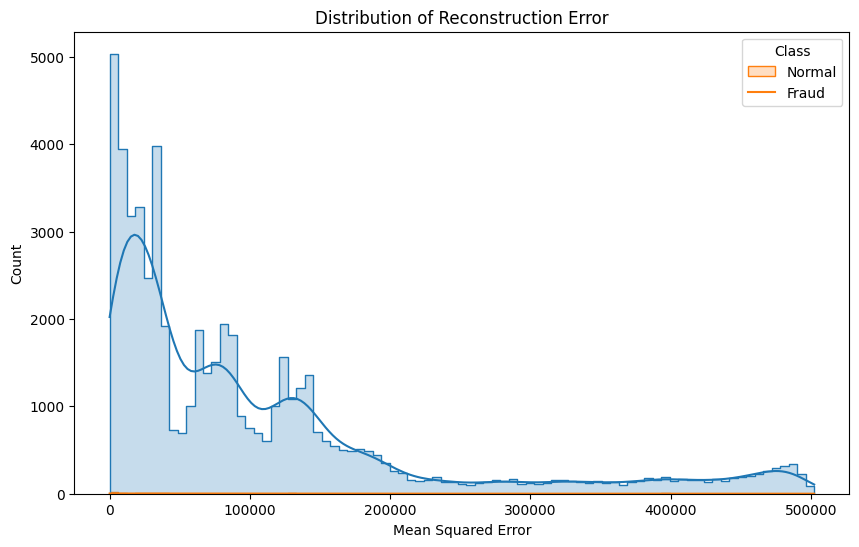

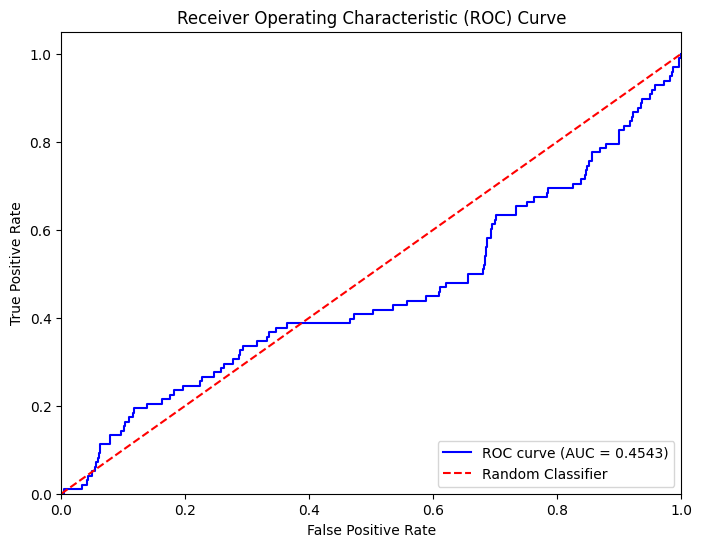

In [43]:
mse = evaluate_model_and_plot(autoencoder, X_test, y_test)